In [1]:
from typing import Literal, Any, Type, Sequence

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter, ImageEnhance, ImageChops

len(tm.masks)=12


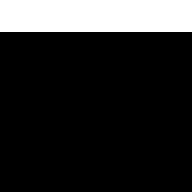

In [2]:
def snap(value: float, multiple: float) -> float:
    return multiple * round(value / multiple)

def coalesce(value: Any, structure: Type) -> Type:
    if isinstance(value, structure):
        return value
    
    if structure == list:
        return [value]
    
    if structure == set:
        return {value,}
    
    if structure == tuple:
        return (value,)
    
    return value

def display_image(img: Image.Image, scale: float = 10) -> None:
    display(ImageOps.scale(img, scale, Image.Resampling.NEAREST))


Shapes = Literal['ort.square', 'ort.rect', 'iso', 'hex.flat', 'hex.point']

class Tile:
    """A framework to deal with Tiles"""
    
    # DUNDERS # ----------------------------------------------------------------
    def __init__(self,
            ref: str | Image.Image | np.typing.NDArray = None,
            shape: Shapes = None,
        ) -> None:
        """The base Tile class for tiling operations
        
        Returns:
            Tile: A PIL.Image wrapped around tiling methods
        """
        
        self.image: Image.Image
        
        if isinstance(ref, Image.Image):
            self.image = ref
        
        elif isinstance(ref, str):
            self.image = Image.open(ref)
        
        elif isinstance(ref, np.ndarray):
            self.image = Image.fromarray(ref)
        
        else:
            self.image = Image.new('RGB', (1, 1), (255, 0, 255))
        
        
        if shape is None:
            w, h = self.size
            shape = 'ort.square' if w == h else 'ort.rect'
        
        self.shape: str = shape
    
    def __repr__(self):
        try:
            display(self.image)
        
        finally:
            return f"size:{self.size} mode:{self.mode} shape:{self.shape}"
    
    # PROPERTIES # -------------------------------------------------------------
    @property
    def mode(self) -> str:
        return self.image.mode
    
    @property
    def size(self) -> tuple[int, int]:
        return self.image.size
    
    @property
    def center(self) -> tuple[float, float]:
        size = self.size
        return size[0]/2, size[1]/2
    
    @property
    def as_mask(self) -> "Tile":
        """Returns the Tile as a mask (only L channel).
        Useful to ensure a mask is indeed a mask.
        
        Returns:
            Tile: The converted Tile.
        """
        
        return Tile(self.image.convert('L'))
    
    @property
    def as_array(self) -> np.typing.NDArray:
        """Returns the Tile as a numpy array.
        Useful for matrix operations.
        
        Returns:
            np.ndarray: The numpy array.
        """
        
        return np.array(self.image)
    
    # METHODS # ----------------------------------------------------------------
    def copy(self) -> "Tile":
        return Tile(self.image.copy(), self.shape)
    
    def display(self,
            factor: float = 1.0,
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> None:
        
        display(ImageOps.scale(self.image, factor, resample))
    
    def invert(self) -> "Tile":
        """'invert' as in 'negative'"""
        
        image = ImageOps.invert(self.image)
        
        return Tile(image, self.shape)
    
    def rotate(self, angle: int, expand: bool = True) -> "Tile":
        image = self.image.rotate(int(angle), expand=expand)
        
        return Tile(image, self.shape)
    
    def mirror(self, axis: Literal['|', '-', '/', '\\']) -> "Tile":
        """Mirrors the Tile in the horizontal, vertical or diagonal directions.  
        
        Args:
            axis ('-', '|', '/', '\\'): Which axis to mirror the image.
        
        Returns:
            Tile: The mirrored Tile.
        """
        
        match axis:
            case '-':  image = ImageOps.flip(self.image)
            case '|':  image = ImageOps.mirror(self.image)
            case '\\': image = self.image.transpose(Image.Transpose.TRANSPOSE)
            case '/':  image = self.image.transpose(Image.Transpose.TRANSVERSE)
            case _:    image = self.image.copy()
        
        return Tile(image, self.shape)
    
    def scale(self,
            factor: float | tuple[float, float],
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> "Tile":
        """'scale' as in 'stretch by factor(x,y) or factor(x==y)'"""
        
        if isinstance(factor, (int, float)):
            image = ImageOps.scale(self.image, factor, resample)
        
        elif isinstance(factor, tuple):
            newsize = (
                int(self.size[0] * factor[0]),
                int(self.size[1] * factor[1]))
            image = self.image.resize(newsize, resample)
        
        else:
            print(f"Strange parameters")
            image = self.image.copy()
        
        return Tile(image, self.shape)
    
    def filter(self,
            filters: ImageFilter.Filter | list[ImageFilter.Filter],
            padding: int = 4,
        ) -> "Tile":
        
        w, h = self.size
        
        # Pads the image with itself to avoid filter bleeding
        image = self.take((w-padding, h-padding), (w+padding*2, h+padding*2)).image
        
        filters = coalesce(filters, list)
        for f in filters:
            image = image.filter(f)
        
        # Crops the extra border, restoring the original size
        image = ImageOps.crop(image, padding)
        
        return Tile(image, self.shape)
    
    def enhance(self, enhancer: ImageEnhance._Enhance, factor: float = 1.0) -> "Tile":
        image = enhancer(self.image).enhance(factor)
        
        return Tile(image, self.shape)
    
    def cutout(self, mask: "Tile") -> "Tile":
        """'cutout' as in 'cookie cutter'"""
        
        image = self.image.copy()
        image.putalpha(mask.as_mask.image)
        
        return Tile(image, mask.shape)
    
    def crop(self, box: tuple[int, int, int, int]) -> "Tile":
        image = self.image.crop(box)
        
        return Tile(image, self.shape)
    
    def take(self, pos: tuple[int, int], size: tuple[int, int]) -> "Tile":
        x0, y0 = pos
        width, height = size
        wrap_width, wrap_height = self.size
        
        xidx = (np.arange(x0, x0+width)  % wrap_width)
        yidx = (np.arange(y0, y0+height) % wrap_height)
        
        crop = self.as_array[np.ix_(yidx, xidx)]
        
        return Tile(crop)
    
    def offset(self, offset: tuple[int, int]) -> "Tile":
        width, height = self.size
        offx, offy = offset
        
        posx = (width + offx) % width
        posy = (height + offy) % height
        
        return self.take((posx, posy), self.size)
    
    def multiply(self, color_tile: "Tile") -> "Tile":
        image = ImageChops.multiply(self.image, color_tile.image)
        
        return Tile(image, self.shape)


class TileOps:
    # STATIC METHODS # ---------------------------------------------------------
    @staticmethod
    def create_symmetrical_outline(
            size: tuple[int, int],
            lines: list[tuple[tuple[float]]],
            **kwargs,
        ) -> Image.Image:
        
        image = Image.new("L", size, 0)
        draw  = ImageDraw.Draw(image)
        
        for line in lines:
            draw.line(line, fill=255)
        
        image.paste(ImageOps.flip(image), mask=ImageOps.invert(image))
        image.paste(ImageOps.mirror(image), mask=ImageOps.invert(image))
        
        return image
    
    @staticmethod
    def create_mask_from_outline(
            base: Image.Image,
            **kwargs,
        ) -> Image.Image:
        
        mask = base.copy()
        width, height = mask.size
        
        ImageDraw.floodfill(mask, (width / 2, height / 2), 255)
        
        return mask
    
    @staticmethod
    def overlay_tiles(base: Tile, head: Tile, mask: Tile = None, alpha: float = 0.5) -> Tile:
        """Merges two tiles into a new one.
        Must have a MASK or alpha value (default, 0.5).
        
        If using a MASK, it must have the same dimensions as both DATA Tiles.
        The pixel values from the MASK range from 0 (full base) to 255 (full head).
        
        The alpha value is used if no MASK is present.
        Its value is applied to the Tiles as a whole, not by pixel.
        
        Args:
            base (Tile): The Tile that goes on the bottom.
            head (Tile): The Tile that goes on top.
            mask (Tile, optional): A special Tile that controls how each pixel is merged. Defaults to None.
            alpha (float, optional): A value that controls how all pixels are merged. Defaults to 0.5.
        
        Returns:
            Tile: A new Tile resulting from the combination of both Tiles.
        """
        
        if mask is None:
            image = Image.blend(base.image, head.image, alpha)
            shape = base.shape
        
        else:
            image = Image.composite(head.image, base.image, mask.as_mask.image)
            shape = mask.shape
        
        return Tile(image, shape)
    
    @staticmethod
    def merge_tiles(*tiles: tuple[Tile, Tile]) -> Tile:
        REFTILE = tiles[0][0]
        REFMASK = tiles[-1][1]
        SIZE = REFTILE.size
        
        image = Image.new('RGBA', SIZE, (0, 0, 0, 0))
        
        for tile, mask in tiles:
            image.paste(tile.image, mask=mask.as_mask.image)
        
        return Tile(image, REFMASK.shape)
    
    @staticmethod
    def merge_masks(*masks: Tile) -> Tile:
        """Adds several MASKs together.
        Their values are combined with bitwise OR.
        
        Returns:
            Tile: A single Tile MASK
        """
        
        assert len(masks) >= 2, "Insufficient masks to be merged (<2)"
        
        base = masks[0].as_mask.as_array
        
        for mask in masks[1:]:
            base |= mask.as_mask.as_array
        
        return Tile(base, masks[-1].shape)
    
    @staticmethod
    def shade_tile(
            base: Tile,
            pattern_mask: Tile,
            offset: tuple[int, int],
            brightness: float = 1.0,
            ordered: bool = True,
        ) -> Tile:
        
        offset_mask = pattern_mask.offset(offset).invert()
        base_adjusted = base.enhance(ImageEnhance.Brightness, brightness)
        
        if ordered: # inverts which is overlaid on the other for double shades
            base, base_adjusted = base_adjusted, base
        base_shaded = TileOps.overlay_tiles(base, base_adjusted, offset_mask)
        
        return base_shaded



TILE_BORDER_INFO: dict[tuple[str, tuple[int, ...]], list[float]] = {
    # (x, y) or (x1, y1, x2, y2)
    ('ort', (1,0,0,0,0,0,0,0)): (0.0, 0.0),             # NW: upper-left corner
    ('ort', (0,1,0,0,0,0,0,0)): (0.0, 0.0, 1.0, 0.0),   # N : upper edge
    ('ort', (0,0,1,0,0,0,0,0)): (1.0, 0.0),             # NE: upper-right corner
    ('ort', (0,0,0,1,0,0,0,0)): (1.0, 0.0, 1.0, 1.0),   # E : right edge
    ('ort', (0,0,0,0,1,0,0,0)): (1.0, 1.0),             # SE: lower-right corner
    ('ort', (0,0,0,0,0,1,0,0)): (1.0, 1.0, 0.0, 1.0),   # S : lower edge
    ('ort', (0,0,0,0,0,0,1,0)): (0.0, 1.0),             # SW: lower-left corner
    ('ort', (1,0,0,0,0,0,0,1)): (0.0, 1.0, 0.0, 0.0),   # W : left edge
    
    ('iso', (1,0,0,0,0,0,0,0)): (0.0, 0.0, 1.0, 0.0),   # N : upper corner
    ('iso', (0,1,0,0,0,0,0,0)): (0.5, 0.0, 1.0, 0.5),   # NE: upper-right edge
    ('iso', (0,0,1,0,0,0,0,0)): (1.0, 0.0, 1.0, 1.0),   # E : right corner
    ('iso', (0,0,0,1,0,0,0,0)): (1.0, 0.5, 0.5, 1.0),   # SE: lower-right edge
    ('iso', (0,0,0,0,1,0,0,0)): (0.0, 1.0, 1.0, 1.0),   # S : lower corner
    ('iso', (0,0,0,0,0,1,0,0)): (0.5, 1.0, 0.0, 0.5),   # SW: lower-left edge
    ('iso', (0,0,0,0,0,0,1,0)): (0.0, 1.0, 0.0, 0.0),   # W : left corner
    ('iso', (0,0,0,0,0,0,0,1)): (0.0, 0.5, 0.5, 0.0),   # NW: upper-left edge
}

class TileGen:
    # MASK GENERATORS # --------------------------------------------------------
    @staticmethod
    def gen_ort_mask(size: int | tuple[int, int], **kwargs) -> Tile:
        """ Generates an orthogonal mask Tile given the size. """
        
        if isinstance(size, int):
            size = (size, size)
        
        mask_image = Image.new('L', size, 255)
        
        # w, h = size
        # lines = [
        #     ((0, 0), (0, h-1)), # left
        #     ((0, 0), (w-1, 0)), # top
        # ]
        
        # outline = TileOps.create_symmetrical_outline(size, lines, **kwargs)
        # mask_image = TileOps.create_mask_from_outline(outline)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_iso_mask(size: int | tuple[int, int], **kwargs) -> Tile:
        """Generates an isometric mask Tile given the size.
        """
        
        if isinstance(size, int):
            size = size//2
            W, H = size*2, size
        else:
            W, H = size
        
        lines = [
            ((0, H/2-1), (W/2-1, 0)), # top-left diagonal
        ]
        
        outline = TileOps.create_symmetrical_outline((W, H), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        return Tile(mask_image, 'iso')
    
    @staticmethod
    def gen_hex_mask(
            size: int | tuple[int, int],
            top: Literal["flat", "point"] = "flat",
            grain: int = 4,
            **kwargs
        ) -> Tile:
        
        if isinstance(size, int):
            assert size % 2 == 0, "Size must be even numbered"
            
            SQRT3BY2 = 0.866
            size = size, int(snap(size*SQRT3BY2, grain)) # nearest multiple of grain
        
        
        # It's easier to always create as a flat top and rotate later
        width, height = size
        
        # Markers (Q.uarter, M.iddle)
        QW, MW = width/4, width/2
        QH, MH = height/4, height/2
        
        # Small correction for widths 8 and 12 (outliers)
        if width in (8, 12):
            QW += 0.5
        
        lines = [
            ((0.5, MH-0.5), (QW-0.5, 0.5)), # top-left diagonal
            ((QW+0.5, 0.5), (MW, 0.5)), # top line
        ]
        
        outline = TileOps.create_symmetrical_outline((width, height), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        if top == 'point':
            mask_image = mask_image.rotate(90, expand=True)
        
        return Tile(mask_image, f'hex.{top}')
    
    @staticmethod
    def gen_shape_mask(
            size: int | tuple[int, int],
            shape: Shapes,
            **params: dict[str, Any],
        ) -> Tile:
        
        if '.' in shape:
            shape, sdev = shape.split('.')
        
        match shape:
            case 'ort':
                return TileGen.gen_ort_mask(size, **params)
            
            case 'iso':
                return TileGen.gen_iso_mask(size, **params)
            
            case 'hex':
                return TileGen.gen_hex_mask(size, sdev, **params)
            
            case _:
                return Tile(None)
    
    # IMAGE GENERATORS # -------------------------------------------------------
    @staticmethod
    def gen_random_rgb(
            size: tuple[int, int],
            ranges: list[tuple[int, int]],
            mode: Literal['minmax', 'avgdev'] = 'minmax',
        ) -> Tile:
        """ Generates a random RGB Tile from the channels ranges. """
        
        size = size[1], size[0]
        
        if mode == 'minmax':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0], ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0], ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0], ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        elif mode == 'avgdev':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0]-ranges[0][1], ranges[0][0]+ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0]-ranges[1][1], ranges[1][0]+ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0]-ranges[2][1], ranges[2][0]+ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        return Tile(image)
    
    @staticmethod
    def gen_random_mask(
            size: tuple[int, int],
            vrange: tuple[int, int],
        ) -> Tile:
        """ Generates a random Mask Tile"""
        
        image = Image.fromarray(np.stack(
            np.random.randint(vrange[0], vrange[1], size, dtype=np.uint8), axis=-1), 'L')
        
        return Tile(image)
    
    @staticmethod
    def gen_texture_tile(
            size: int | tuple[int, int],
            texture_name: str,
            **kwargs,
        ) -> Tile:
        
        if isinstance(size, int):
            size = (size, size)
        
        FULL_SIZE = size
        HALF_SIZE = size[0]//2, size[1]//2
        HALF_WIDTH = size[0]//2, size[1]
        QUARTER_HEIGHT = size[0], size[1]//4
        
        tile: Tile = None
        
        match texture_name.lower():
            case 'grass':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((48, 64), (64, 108), (24, 32)))
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.9)
                )
            case 'grass.dry': # path
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((80, 8), (80, 8), (24, 4)), 'avgdev')
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.66)
                )
            case 'grass.wet': # moss
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((48, 4), (64, 4), (24, 4)), 'avgdev')
                    #.filter([ImageFilter.SMOOTH_MORE])
                )
            
            case 'water':
                tile = (TileGen
                    .gen_random_rgb(HALF_WIDTH, ((24, 32), (32, 48), (80, 120)))
                    .scale((2, 1))
                    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            case 'water.shallow': # puddle
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((64, 8), (72, 8), (120, 12)), 'avgdev')
                    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            
            case 'dirt':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((140, 160), (100, 120), (64, 80)))
                    .filter([ImageFilter.SMOOTH_MORE])
                )
            case 'dirt.wet': # mud
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((100, 6), (72, 6), (56, 4)), 'avgdev')
                    .filter([ImageFilter.SMOOTH])
                )
            
            case 'sand':
                tile = (TileGen
                    .gen_random_rgb(HALF_SIZE, ((100, 108), (100, 108), (100, 108)))
                    .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.2)
                )
            case 'clay':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((108, 120), (64, 80), (48, 64)))
                    .filter([ImageFilter.SMOOTH_MORE])
                )
            
            case 'stone':
                tile = (TileGen
                    .gen_random_rgb(HALF_SIZE, ((100, 112), (100, 112), (100, 112)))
                    .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.2)
                )
            case 'gravel':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((96, 48), (96, 48), (96, 12)), 'avgdev')
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.05)
                )
            
            case 'wood':
                tile = (TileGen
                    .gen_random_rgb(QUARTER_HEIGHT, ((80, 8), (32, 6), (16, 4)), 'avgdev')
                    .scale((1, 4))
                    .filter([ImageFilter.BLUR])
                    .enhance(ImageEnhance.Contrast, 0.666)
                    .enhance(ImageEnhance.Color, 0.666)
                    .enhance(ImageEnhance.Brightness, 1.333)
                )
            
            # case '':
            #     return
            
            case _:
                tile = Tile()
        
        return tile
    
    @staticmethod
    def gen_brick_pattern_mask(
            size: tuple[int, int],
            brick_size: tuple[int, int],
            gap_width: int = 0,
            edge_width: int = 0,
            **params: dict[str, Any],
        ) -> Tile:
        """Works with:
        ```
        gap_width  | 1 | 2 | 3 | 4 | 5 | 6 | ...
        edge_width | * | * | * | X | * | ? | ...
        ```
        """
        
        MW, MH = size       # Mask Width and Height
        BW, BH = brick_size # Brick Width and Height
        BRW = MW + 2*BW     # Brick Row Width
        HBW = BW//2         # Half Brick Width
        BASE_VALUE = params.get('base_value', 0)
        FILL_VALUE = params.get('fill_value', 255)
        ROW_OFFSET = params.get('row_offset', HBW)
        INVERT     = params.get('invert', True)
        
        brick_template = Image.new('L', brick_size, BASE_VALUE)
        brick_temp_canv = ImageDraw.Draw(brick_template)
        brick_temp_canv.line(((0.5, 0.5), (BW+0.5, 0.5)), FILL_VALUE, gap_width)
        brick_temp_canv.line(((HBW+0.5, 0.5), (HBW+0.5, BH+0.5)), FILL_VALUE, gap_width)
        
        # Some fuckery, don't mess with it
        if edge_width:
            CO = gap_width / 2 if gap_width % 2 == 0 else 0.5 * gap_width
            polyconf = dict(n_sides=4, rotation=45, fill=FILL_VALUE)
            
            rad = edge_width + gap_width
            brick_temp_canv.regular_polygon((HBW+0.5, 0.5, rad), **polyconf)
            brick_temp_canv.regular_polygon((HBW+0.5, BH+CO, rad), **polyconf)
            
            if gap_width % 2 == 0:
                brick_temp_canv.regular_polygon((HBW+CO+0.5, 0.5, rad), **polyconf)
                brick_temp_canv.regular_polygon((HBW+CO+0.5, BH+CO+0.5, rad), **polyconf)
        
        # Builds the single brick row with the single brick template
        brick_row = Image.new('L', (BRW, BH), BASE_VALUE)
        for col in range(0, BRW, BW):
            brick_row.paste(brick_template, (col, 0))
        
        # Pastes the brick row template on each new row
        # The offset can be overriden with `row_offset=<int>`
        mask_image  = Image.new("L", size, BASE_VALUE)
        
        for cnt, row in enumerate(range(0, MH, BH)):
            #offset = (cnt * ROW_OFFSET) % BW - (HBW + BW)
            offset = (cnt % 2) * ROW_OFFSET - (HBW + BW)
            #offset = (cnt * BW) % ROW_OFFSET - (HBW + BW)
            
            mask_image.paste(brick_row, (offset, row))
        
        if INVERT:
            mask_image = ImageOps.invert(mask_image)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_line_draw_mask(
            size: tuple[int, int],
            lines: Sequence[tuple[float, float, float, float]],
            **params: dict[str, Any],
        ) -> Tile:
        """
        ```
        size = (10, 10)
        lines = [
            ((x0, y0), (x1, y1), width),
            ...
        ]
        ```
        """
        
        BASE_VALUE = params.get('base_value', 0)
        FILL_VALUE = params.get('fill_value', 255)
        INVERT = params.get('invert', True)
        
        mask_image = Image.new('L', size, BASE_VALUE)
        canvas = ImageDraw.Draw(mask_image)
        
        for line in lines:
            p0, p1, width = line
            canvas.line((p0, p1), FILL_VALUE, width)
        
        if INVERT:
            mask_image = ImageOps.invert(mask_image)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_line_border_mask(
            size: int | tuple[int, int],
            shape: Shapes,
            edges: tuple[int, ...],
            width: int = 1,
            **params: dict[str, Any],
        ) -> Tile:
        
        FILL = params.get('fill', 255)
        
        shape_mask = TileGen.gen_shape_mask(size, shape)
        mask_image = Image.new('L', shape_mask.size, 0)
        canvas = ImageDraw.Draw(mask_image)
        
        # F.ull, A.djusted, W.idth, H.eight, O.ffset
        FW, FH = shape_mask.size
        AW, AH = FW-1, FH-1
        
        if shape == 'ort':
            OFF = 0.5
            ALW = int(2*(width-0.5)) # Adjusted Line Width (Thickness)
        elif shape == 'iso':
            OFF = 0.0
            ALW = width//2
        # x * AW + O
        # y + AH + O
        
        edge_lists = []
        
        for idx, edge in enumerate(edges):
            if not edge: continue
            
            ph = ([0]*8)
            ph[idx] = 1
            edge_lists.append(tuple(ph))
        
        lines: list[tuple[float, ...]] = []
        
        # Queries all edge instructions
        for edge in edge_lists:
            points = TILE_BORDER_INFO.get((shape, edge))
            lines.append(points)
        
        for points in lines:
            # It's a point coordinate, such as a corner
            if len(points) == 2:
                xs = (x*AW for x in points[0::2])
                ys = (y*AH for y in points[1::2])
                adjpoints = tuple(item for tup in zip(xs, ys) for item in tup)
                
                if width == 1:
                    canvas.point(adjpoints, FILL)
                else:
                    canvas.circle(adjpoints, width-1, FILL)
            
            # It's a line coordinate, such as an edge
            else:
                xs = (x*AW + OFF for x in points[0::2])
                ys = (y*AH + OFF for y in points[1::2])
                adjpoints = tuple(item for tup in zip(xs, ys) for item in tup)
                canvas.line(adjpoints, FILL, ALW)
        
        return Tile(mask_image).cutout(shape_mask)



# Shape: 'ort.square', 'ort.rect', 'iso', 'hex.flat', 'hex.point'
# Operation: rotation(angle), mirror(axis)
# Value: angle or axis

TILE_MOVE_INFO: dict[tuple[str, str, int|str], tuple[int, ...]] = {
    # ORTHOGONAL SQUARE/RECTANGLE ---------------------------------
    # Rotation
    # | 0     | 90    | 180   | 270   |
    # | 1 2 3 | 3 4 5 | 5 6 7 | 7 8 1 |
    # | 8 0 4 | 2 0 6 | 4 0 8 | 6 0 2 |
    # | 7 6 5 | 1 8 7 | 3 2 1 | 5 4 3 |
    ('ort', 'rotation', 90 ): (3, 4, 5, 6, 7, 8, 1, 2), # s-2
    ('ort', 'rotation', 180): (5, 6, 7, 8, 1, 2, 3, 4), # s-4
    ('ort', 'rotation', 270): (7, 8, 1, 2, 3, 4, 5, 6), # s+2
    
    # Mirror
    # | 0     | '|'   | '-'   | '/'   | '\'   |
    # | 1 2 3 | 3 2 1 | 7 6 5 | 5 4 3 | 1 8 7 |
    # | 8 0 4 | 4 0 8 | 8 0 4 | 6 0 2 | 2 0 6 |
    # | 7 6 5 | 5 6 7 | 1 2 3 | 7 8 1 | 3 4 5 |
    ('ort', 'mirror', '|' ): (3, 2, 1, 8, 7, 6, 5, 4), # i s+3
    ('ort', 'mirror', '-' ): (7, 6, 5, 4, 3, 2, 1, 8), # i s-1
    ('ort', 'mirror', '/' ): (5, 4, 3, 2, 1, 8, 7, 6), # i s-3
    ('ort', 'mirror', '\\'): (1, 8, 7, 6, 5, 4, 3, 2), # i s+1
    
    # ISOMETRIC ---------------------------------------------------
    # Rotation
    # | 0         | 90        | 180       | 270       |
    # |     1     |           |     5     |           |
    # |   8   2   |           |   4   6   |           |
    # | 7   0   3 |     X     | 3   0   7 |     X     |
    # |   6   4   |           |   2   8   |           |
    # |     5     |           |     1     |           |
    ('iso', 'rotation', 180): (5, 6, 7, 8, 1, 2, 3, 4), # s+4
    
    # Mirror
    # | 0         | '|'       | '-'       | '/'       | '\'       |
    # |     1     |     1     |     5     |           |           |
    # |   8   2   |   2   8   |   6   4   |           |           |
    # | 7   0   3 | 3   0   7 | 7   0   3 |     X     |     X     |
    # |   6   4   |   4   6   |   8   2   |           |           |
    # |     5     |     5     |     1     |           |           |
    ('iso', 'mirror', '|'): (1, 8, 7, 6, 5, 4, 3, 2), # i s+1
    ('iso', 'mirror', '-'): (5, 4, 3, 2, 1, 8, 7, 6), # i s-3
    
    # HEXAGONAL ---------------------------------------------------
    # FLAT
    # Rotation
    # | 0     | 90    | 180   | 270   |
    # |  1 2  |       |  4 5  |       |
    # | 6 0 3 |   X   | 3 0 6 |   X   |
    # |  5 4  |       |  2 1  |       |
    ('hex.flat', 'rotation', 180): (4, 5, 6, 1, 2, 3), # s+3
    
    # Mirror
    # | 0     | '|'   | '-'   | '/'   | '\'   |
    # |  1 2  |  2 1  |  5 4  |       |       |
    # | 6 0 3 | 3 0 6 | 6 0 3 |   X   |   X   |
    # |  5 4  |  4 5  |  1 2  |       |       |
    ('hex.flat', 'mirror', '|'): (2, 1, 6, 5, 4, 3), # i s+2
    ('hex.flat', 'mirror', '-'): (5, 4, 3, 2, 1, 6), # i s-1
    
    # POINT
    # Rotation
    # | 0     | 90    | 180   | 270   |
    # |   1   |       |   4   |       |
    # | 6 0 2 |   X   | 3 0 5 |   X   |
    # | 5   3 |       | 1   6 |       |
    # |   4   |       |   1   |       |
    ('hex.point', 'rotation', 180): (4, 5, 6, 1, 2, 3), # s+3
    
    # Mirror
    # | 0     | '|'   | '-'   | '/'   | '\'   |
    # |   1   |   1   |   4   |       |       |
    # | 6 0 2 | 2 0 6 | 5 0 3 |   X   |   X   |
    # | 5   3 | 3   4 | 6   2 |       |       |
    # |   4   |   4   |   1   |       |       |
    ('hex.point', 'mirror', '|'): (1, 6, 5, 4, 3, 2), # i s+1
    ('hex.point', 'mirror', '-'): (4, 3, 2, 1, 6, 5), # i s-2
}

# https://stackoverflow.com/questions/2150108/efficient-way-to-rotate-a-list-in-python
def shift_list(_list: list, shift: int = 0, invert: bool = False) -> list:
    seq = _list.copy()
    
    if invert:
        seq = seq[::-1]
    
    for s in range(abs(shift)):
        if shift < 0:
            seq.append(seq.pop(0))
        
        if shift > 0:
            seq.insert(0, seq.pop(-1))
    
    return seq


class TileMasks:
    def __init__(self, shape: Shapes):
        self.shape: str = shape
        self.masks: dict[tuple[int, ...], Tile] = {}
    
    @staticmethod
    def combine_masks(
            mask1: Tile,
            edge1: tuple[int, ...],
            mask2: Tile,
            edge2: tuple[int, ...],
        ) -> tuple[Tile, tuple[int]]:
        
        edge = [edge1[idx] | edge2[idx] for idx in range(len(edge1))]
        mask = TileOps.merge_masks(mask1, mask2)
        
        return mask, edge
    
    @staticmethod
    def load_ort(
            corner_NW: Tile = None,
            border_N: Tile = None,
            curve_NE: Tile = None,
        ) -> "TileMasks":
        """
        asdasdasd
        
        ```
        corner_NW | border_N | curve_NE
        1 0 0     | 1 1 1    | 0 1 1
        0 x 0     | 0 x 0    | 0 x 1
        0 0 0     | 0 0 0    | 0 0 0
        ```
        """
        
        tm = TileMasks('ort')
        BASE_IDXS = list(range(1, 9))
        
        for rot in (0, 90, 180, 270):
            idxs = TILE_MOVE_INFO.get((tm.shape, 'rotation', rot), BASE_IDXS)
            
            # Corners => 4
            base_edge = (1,0,0,0,0,0,0,0)
            edges = tuple([base_edge[idx-1] for idx in idxs])
            tm.masks[edges] = corner_NW.rotate(rot)
            
            # Borders => 4
            base_edge = (1,1,1,0,0,0,0,0)
            edges = tuple([base_edge[idx-1] for idx in idxs])
            tm.masks[edges] = border_N.rotate(rot)
            
            # Curves => 4
            base_edge = (0,1,1,1,0,0,0,0)
            edges = tuple([base_edge[idx-1] for idx in idxs])
            tm.masks[edges] = curve_NE.rotate(rot)
        
        print(f"{len(tm.masks)=}")
        
        return tm
    
    def find(self, edges: tuple[int, ...]) -> Tile:
        
        mask = self.masks.get(edges)
        if mask is not None:
            return mask
        
        closest_edge: Tile = None
        min_distance: float = float('inf')
        
        for edge, mask in self.masks.items():
            dist = sum([(x - y) ** 2 for x, y in zip(edge, edges)]) ** 0.5
            
            if dist < min_distance:
                min_distance = dist
                closest_edge = edge
        
        mask = self.masks.get(closest_edge)
        if mask is not None:
            return mask
        
        return Tile(None)



corner = TileGen.gen_line_border_mask(24, 'ort', (1,0,0,0,0,0,0,0), 4)
border = TileGen.gen_line_border_mask(24, 'ort', (1,1,1,0,0,0,0,0), 4)
curve  = TileGen.gen_line_border_mask(24, 'ort', (0,1,1,1,0,0,0,0), 5)

tm = TileMasks.load_ort(corner,border,curve)

tm.find((0,1,1,0,0,0,0,0)).display(8)

In [ ]:
edges = (1,0,0,0,0,0,0,0)
angle = 90

idxs = TILE_MOVE_INFO.get(('ort', 'rotation', angle))
print(f"{idxs=}")

newedges = [edges[idx-1] for idx in idxs]
print(f"{newedges=}")


In [ ]:
SCALE = 8
SIZE = 24
SHAPE = 'iso'
WIDTHS = (
    1, 2, 3,
    # 4, 5, 6,
    # 7, 8, 9,
)

EDGES = (1,0,1,0,1,0,1,0)
for w in WIDTHS:
    TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w)#.display(SCALE)

EDGES = (0,1,0,1,0,1,0,1)
for w in WIDTHS:
    TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w)#.display(SCALE)

EDGES = (0,1,1,1,0,0,1,0)
for w in WIDTHS:
    TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w).display(SCALE)

In [ ]:
SCALE = 8
SIZE = 24
SHAPE = 'ort'
WIDTHS = (
    1, 2, 3,
    4, 5, 6,
    # 7, 8, 9,
)

# EDGES = (1,0,1,0,1,0,1,0)
# for w in WIDTHS:
#     TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w).display(SCALE)

# EDGES = (0,1,0,1,0,1,0,1)
# for w in WIDTHS:
#     TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w).display(SCALE)

EDGES = (0,1,1,1,0,0,1,0)
for w in WIDTHS:
    TileGen.gen_line_border_mask(SIZE, SHAPE, EDGES, w).display(SCALE)

# Examples:

In [ ]:
SCALE = 4
SIZE = (48, 48)
PLANK_SIZE = (SIZE[0]-2, SIZE[1]//4)
GAP_WIDTH = 3
EDGE_WIDTH = 1
SHADE_FORCE = 0.80

base_mask = TileGen.gen_ort_mask(SIZE)
head_mask1 = TileGen.gen_line_draw_mask(SIZE, [((SIZE[0]//4-0.5, 0), (SIZE[0]//4-0.5, SIZE[1]), 8), ((SIZE[0]-SIZE[0]//4-0.5, 0), (SIZE[0]-SIZE[0]//4-0.5, SIZE[1]), 8)], invert=False)
head_mask2 = TileGen.gen_brick_pattern_mask(SIZE, PLANK_SIZE, GAP_WIDTH, EDGE_WIDTH, row_offset=1).offset((0, 1))
head_mask1_2 = TileOps.merge_masks(head_mask1, head_mask2)

head_mask1.display(SCALE//2)
head_mask2.display(SCALE//2)

base_tile = TileOps.shade_tile(TileGen.gen_texture_tile(SIZE, 'water'), head_mask1_2, (-2, -3), SHADE_FORCE, True)
head_tile = TileGen.gen_texture_tile(SIZE, 'wood')
head_tile1 = TileOps.shade_tile(head_tile.enhance(ImageEnhance.Brightness, SHADE_FORCE), head_mask2, (1, 1), SHADE_FORCE, False)
head_tile2 = TileOps.shade_tile(head_tile.rotate(90), head_mask2, (1, 1), SHADE_FORCE, False)

TileOps.merge_tiles(
    (base_tile, base_mask),
    (head_tile1, head_mask1),
    (head_tile2, head_mask2),
).display(SCALE)

In [ ]:
SCALE = 4
SIZE = 48
BRICK_SIZE = (SIZE//4, SIZE//4)
GAP_WIDTH = 2
EDGE_WIDTH = 1
SHADE_FORCE = 0.80

shape_mask = TileGen.gen_ort_mask(SIZE)
pattern_mask = TileGen.gen_brick_pattern_mask(shape_mask.size, BRICK_SIZE, GAP_WIDTH, EDGE_WIDTH)
pattern_mask.display(SCALE)

base_tile = TileGen.gen_texture_tile(shape_mask.size, 'grass')
head_tile = TileGen.gen_texture_tile(shape_mask.size, 'gravel')

shaded_base = TileOps.shade_tile(base_tile, pattern_mask, (1, -1), SHADE_FORCE, True)
shaded_head = TileOps.shade_tile(head_tile, pattern_mask, (-1, 1), SHADE_FORCE, False)

combined = TileOps.overlay_tiles(shaded_base, shaded_head, pattern_mask)
combined.display(SCALE)

In [ ]:
SCALE = 4
SIZE = 48
BRICK_SIZE = (SIZE//2, SIZE//4)
GAP_WIDTH = 2
EDGE_WIDTH = 1
SHADE_FORCE = 0.75

shape_mask = TileGen.gen_ort_mask(SIZE)
pattern_mask = TileGen.gen_brick_pattern_mask(shape_mask.size, BRICK_SIZE, GAP_WIDTH, EDGE_WIDTH)
pattern_mask.display(SCALE)

base_tile = TileGen.gen_texture_tile(shape_mask.size, 'gravel')
head_tile = TileGen.gen_texture_tile(shape_mask.size, 'clay')

shaded_base = TileOps.shade_tile(base_tile, pattern_mask, (1, -1), SHADE_FORCE, True)
shaded_head = TileOps.shade_tile(head_tile, pattern_mask, (-1, 1), SHADE_FORCE, False)

combined = TileOps.overlay_tiles(shaded_base, shaded_head, pattern_mask)
combined.display(SCALE)

In [ ]:
scale = 2
mask = TileGen.gen_hex_mask(64, 'flat')
pattern_mask = TileGen.gen_brick_pattern_mask(mask.size, (8, 5), 1, 1)
base = TileGen.gen_texture_tile(mask.size, 'stone')
head = TileGen.gen_texture_tile(mask.size, 'clay')
brick_mortar = TileOps.overlay_tiles(base, head, pattern_mask)
brick_mortar_tile = brick_mortar.copy().cutout(mask)


print("Base texture")
base.display(scale)

print("Head texture")
head.display(scale)

print("Brick pattern mask")
pattern_mask.display(scale)

print("Overlay result")
brick_mortar.display(scale)

print("Hexagonal cut mask")
mask.display(scale)

print("Final result")
brick_mortar_tile.display(scale)

In [ ]:
SCALE = 2

print("Grass")
(TileGen
    .gen_random_rgb((96, 96), ((48, 64), (64, 108), (24, 32)))
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
).display(SCALE)

print("DryGrass")
(TileGen
    .gen_random_rgb((96, 96), ((80, 8), (80, 8), (24, 4)), 'avgdev')
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.66)
).display(SCALE)

print("Moss")
(TileGen
    .gen_random_rgb((96, 96), ((48, 4), (64, 4), (24, 4)), 'avgdev')
    #.filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Water")
(TileGen
    .gen_random_rgb((96, 96), ((24, 32), (32, 48), (80, 120)))
    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
).display(SCALE)

print("Dirt")
(TileGen
    .gen_random_rgb((96, 96), ((140, 160), (100, 120), (64, 80)))
    .filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Mud")
(TileGen
    .gen_random_rgb((96, 96), ((100, 6), (72, 6), (56, 4)), 'avgdev')
    .filter([ImageFilter.SMOOTH])
).display(SCALE)

print("Sand")
(TileGen
    .gen_random_rgb((96, 96), ((240, 255), (200, 220), (180, 192)))
    .filter([ImageFilter.SMOOTH])
).display(SCALE)

print("Clay")
(TileGen
    .gen_random_rgb((96, 96), ((108, 120), (64, 80), (48, 64)))
    .filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Stone")
(TileGen
    .gen_random_rgb((48, 48), ((100, 108), (100, 108), (100, 108)))
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.2)
).display(SCALE)

print("Gravel")
(TileGen
    .gen_random_rgb((48, 48), ((96, 48), (96, 48), (96, 12)), 'avgdev')
    .filter([ImageFilter.SMOOTH_MORE])
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.05)
).display(SCALE)


In [ ]:
# TileGen.gen_hex_mask((24, 12), 'flat', 4).display(4)
# TileGen.gen_iso_mask(24).display(4)
(TileGen
    .gen_random_rgb((24, 12), ((48, 64), (64, 108), (24, 32)))
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
    .cutout(TileGen.gen_iso_mask(24))
).display(4)

In [ ]:
image = Tile('iso.png').image.convert('RGB')
display_image(image, 10)

W, H = image.size

x1, y1 = 0, H
x2, y2 = W, 0

A = y2 - y1 
B = -(x2 - x1)
C = (-A * x1) - (B * y1)
M = (A*A + B*B) ** 0.5

A_ = A / M
B_ = B / M
C_ = C / M


newimg = Image.new('RGB', image.size, (0, 0, 0))
display_image(newimg, 10)

def clamp(value: float, _range: tuple[float, float]) -> Any:
    if value < _range[0]: return _range[0]
    if value > _range[1]: return _range[1]
    return value


print(f"{W=} {H=}")

for c in range(image.size[0]):
    for r in range(image.size[1]):
        p = image.getpixel((c, r))
        
        D = A_*c + B_*r + C_
        Px = int(clamp(c - 2*A_*D, (0, W-1)))
        Py = int(clamp(r - 2*B_*D, (0, H-1)))
        
        newimg.putpixel((Px, Py), p)

display_image(newimg, 10)

In [ ]:
from PIL import Image, ImageTransform

image = Image.open("test.png")
display_image(image, 8)



# Define the shear factor (e.g., 0.5 for moderate shear)
shear_x = 1.0  # x-shear
shear_y = 0.0  # no y-shear

# Construct the 6-tuple affine matrix for shearing
# Affine matrix is (a, b, c, d, e, f)
# For shear in x-direction: b = shear_x
# Transformation matrix:
# | a  b  c |
# | d  e  f |
# | 0  0  1 |

# sx=-1 -> image.size[0] + (image.size[0] * shear_x)
# sx=1  -> -(image.size[0] * shear_x)
matrix = (
    1,       shear_x, -(image.size[0] * shear_x),
    shear_y,       1, 0,
    0,             0, 1,
) 

# Create AffineTransform object
transform = ImageTransform.AffineTransform(matrix)

resize = (
    int(image.size[0] * (1 + abs(shear_x))),
    int(image.size[1] * (1 + abs(shear_y))),
)

sheared_image = image.transform(resize, transform, resample=Image.Resampling.NEAREST)

display_image(sheared_image, 8)